# **Data Loading & Dynamic Augmentation**

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

dataset_dir = r"D:\Suvan's Projects\FYP\EditAugment"

# Resize images to 224x224 as required by VGG-19
imageSize = (224, 224)

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Rotate images by up to 30 degrees
    width_shift_range=0.2,  # Shift width by up to 20%
    height_shift_range=0.2, # Shift height by up to 20%
    shear_range=0.2,        # Apply shear transformation
    zoom_range=0.2,         # Random zooming
    horizontal_flip=True,   # Flip images horizontally
    brightness_range=[0.8, 1.2]  # Adjust brightness randomly
)

# Normalization only for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load the datasets
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size=imageSize,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "val"),
    target_size=imageSize,
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "test"),
    target_size=imageSize,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

stressTest_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, "stressTest"),
    target_size=imageSize,
    batch_size=32,
    class_mode='categorical'
)

Found 1455 images belonging to 4 classes.
Found 64 images belonging to 4 classes.
Found 63 images belonging to 4 classes.
Found 252 images belonging to 4 classes.


# **Creating Base MobileNet model & Retrain on Dataset**

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 484ms/step - accuracy: 0.4791 - loss: 1.2869 - val_accuracy: 0.7344 - val_loss: 0.5425
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 408ms/step - accuracy: 0.8146 - loss: 0.4943 - val_accuracy: 0.8281 - val_loss: 0.4210
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 418ms/step - accuracy: 0.8791 - loss: 0.3264 - val_accuracy: 0.7969 - val_loss: 0.4721
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 473ms/step - accuracy: 0.9364 - loss: 0.2070 - val_accuracy: 0.7969 - val_loss: 0.4926
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 520ms/step - accuracy: 0.9231 - loss: 0.2107 - val_accuracy: 0.7969 - val_loss: 0.6277
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 537ms/step - accuracy: 0.9630 - loss: 0.1369 - val_accuracy: 0.7812 - val_loss: 0.5604
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 434ms/step - accuracy: 0.9498 - loss: 0.1358 - val_accuracy: 0.7656 - val_loss: 0.5562
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 475ms/step - accuracy: 0.9695 - loss: 0.0952 - val_accu

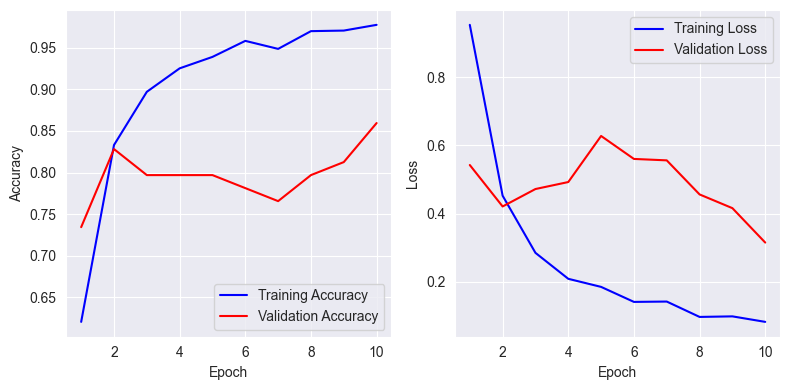

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers except last 5 for re-training
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Define input shape explicitly
inputs = Input(shape=(224, 224, 3))

# Connect base model
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Plotting the accuracy/epoch loss
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs = range(1,len(acc2) +1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize= (8,4))
axes[0].plot(epochs, acc2, 'b', label= 'Training Accuracy')
axes[0].plot(epochs, val_acc2, 'r', label= 'Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss2, 'b', label= 'Training Loss')
axes[1].plot(epochs, val_loss2, 'r', label= 'Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 807ms/step


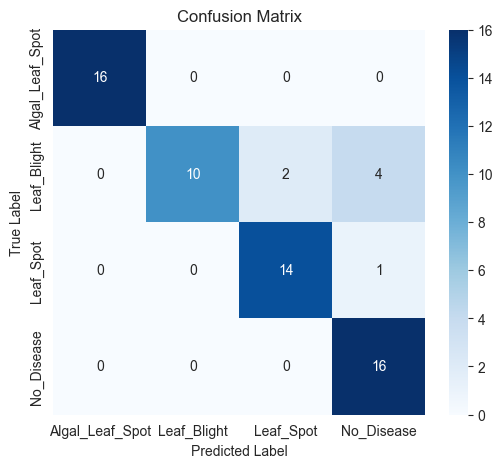

Classification Report:
                  precision    recall  f1-score   support

Algal_Leaf_Spot       1.00      1.00      1.00        16
    Leaf_Blight       1.00      0.62      0.77        16
      Leaf_Spot       0.88      0.93      0.90        15
     No_Disease       0.76      1.00      0.86        16

       accuracy                           0.89        63
      macro avg       0.91      0.89      0.88        63
   weighted avg       0.91      0.89      0.88        63

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8634 - loss: 0.3626
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.7892 - loss: 0.5292
Test Accuracy       : 88.89%
Stress Test Accuracy: 85.32%


In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Get the true labels from the validation generator
true_labels = test_generator.classes  # Actual class labels

# Get class labels mapping
class_labels = list(test_generator.class_indices.keys())

# Get model predictions (probabilities)
pred_probs = model.predict(test_generator)

# Convert probabilities to class indices
pred_labels = np.argmax(pred_probs, axis=1)  # Predicted class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report:\n", report)

test_loss, test_acc = model.evaluate(test_generator)
stress_loss, stress_acc = model.evaluate(stressTest_generator)
print("================================")
print(f"Test Accuracy       : {test_acc* 100:.2f}%")
print(f"Stress Test Accuracy: {stress_acc* 100:.2f}%")
print("================================")

# **Fine-Tuning model by unfreezing layers**

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 475ms/step - accuracy: 0.9719 - loss: 0.0865 - val_accuracy: 0.8125 - val_loss: 0.3719
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 493ms/step - accuracy: 0.9803 - loss: 0.0678 - val_accuracy: 0.8125 - val_loss: 0.3223
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 516ms/step - accuracy: 0.9755 - loss: 0.0717 - val_accuracy: 0.8750 - val_loss: 0.2636
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 497ms/step - accuracy: 0.9805 - loss: 0.0663 - val_accuracy: 0.8750 - val_loss: 0.2319
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 540ms/step - accuracy: 0.9846 - loss: 0.0589 - val_accuracy: 0.9062 - val_loss: 0.1927
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 517ms/step - accuracy: 0.9804 - loss: 0.0638 - val_accuracy: 0.9219 - val_loss: 0.1853
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 490ms/step - accuracy: 0.9785 - loss: 0.0603 - val_accuracy: 0.9219 - val_loss: 0.1643
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 508ms/step - accuracy: 0.9770 - loss: 0.0736 - val_accu

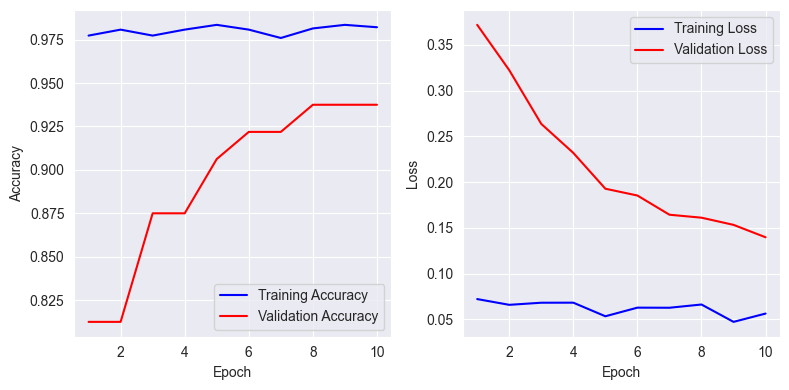

In [12]:
# Unfreeze LAST 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train again
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Plotting the accuracy/epoch loss
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs = range(1,len(acc2) +1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize= (8,4))
axes[0].plot(epochs, acc2, 'b', label= 'Training Accuracy')
axes[0].plot(epochs, val_acc2, 'r', label= 'Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss2, 'b', label= 'Training Loss')
axes[1].plot(epochs, val_loss2, 'r', label= 'Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


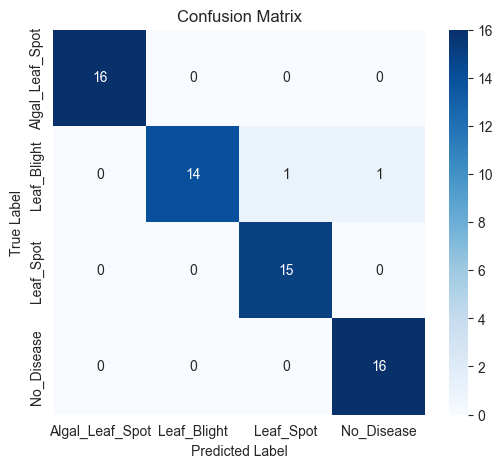

Classification Report:
                  precision    recall  f1-score   support

Algal_Leaf_Spot       1.00      1.00      1.00        16
    Leaf_Blight       1.00      0.88      0.93        16
      Leaf_Spot       0.94      1.00      0.97        15
     No_Disease       0.94      1.00      0.97        16

       accuracy                           0.97        63
      macro avg       0.97      0.97      0.97        63
   weighted avg       0.97      0.97      0.97        63

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9580 - loss: 0.1194
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.9089 - loss: 0.2871
Test Accuracy       : 96.83%
Stress Test Accuracy: 93.25%


In [16]:
true_labels = test_generator.classes  # Actual class labels

# Get class labels mapping
class_labels = list(test_generator.class_indices.keys())

# Get model predictions (probabilities)
pred_probs = model.predict(test_generator)

# Convert probabilities to class indices
pred_labels = np.argmax(pred_probs, axis=1)  # Predicted class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report:\n", report)

test_loss, test_acc = model.evaluate(test_generator)
stress_loss, stress_acc = model.evaluate(stressTest_generator)
print("================================")
print(f"Test Accuracy       : {test_acc* 100:.2f}%")
print(f"Stress Test Accuracy: {stress_acc* 100:.2f}%")
print("================================")

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 433ms/step - accuracy: 0.9863 - loss: 0.0589 - val_accuracy: 0.9375 - val_loss: 0.1257
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 414ms/step - accuracy: 0.9817 - loss: 0.0635 - val_accuracy: 0.9688 - val_loss: 0.0993
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.9837 - loss: 0.0506 - val_accuracy: 0.9688 - val_loss: 0.0966
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - accuracy: 0.9761 - loss: 0.0612 - val_accuracy: 0.9531 - val_loss: 0.0980
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 510ms/step - accuracy: 0.9871 - loss: 0.0456 - val_accuracy: 0.9688 - val_loss: 0.0916
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 519ms/step - accuracy: 0.9791 - loss: 0.0661 - val_accuracy: 0.9688 - val_loss: 0.0889
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 518ms/step - accuracy: 0.9888 - loss: 0.0409 - val_accuracy: 0.9688 - val_loss: 0.0759
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 532ms/step - accuracy: 0.9876 - loss: 0.0490 - val_accu

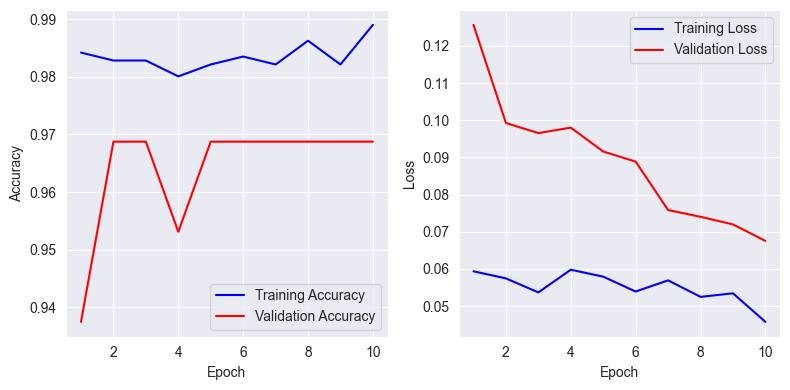

In [18]:
# Unfreeze LAST 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train again
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Plotting the accuracy/epoch loss
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs = range(1,len(acc2) +1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize= (8,4))
axes[0].plot(epochs, acc2, 'b', label= 'Training Accuracy')
axes[0].plot(epochs, val_acc2, 'r', label= 'Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss2, 'b', label= 'Training Loss')
axes[1].plot(epochs, val_loss2, 'r', label= 'Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 917ms/step


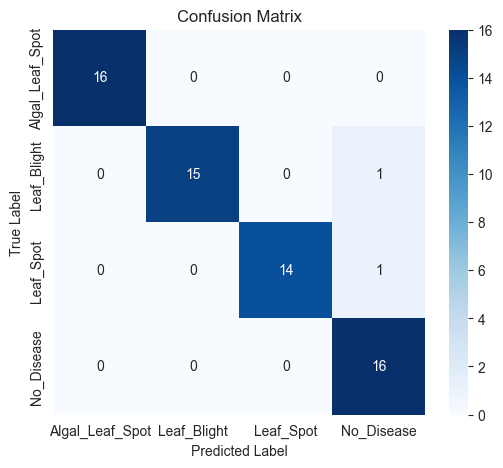

Classification Report:
                  precision    recall  f1-score   support

Algal_Leaf_Spot       1.00      1.00      1.00        16
    Leaf_Blight       1.00      0.94      0.97        16
      Leaf_Spot       1.00      0.93      0.97        15
     No_Disease       0.89      1.00      0.94        16

       accuracy                           0.97        63
      macro avg       0.97      0.97      0.97        63
   weighted avg       0.97      0.97      0.97        63

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.9684 - loss: 0.0470
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.9446 - loss: 0.1097
Test Accuracy       : 96.83%
Stress Test Accuracy: 96.43%


In [19]:
true_labels = test_generator.classes  # Actual class labels

# Get class labels mapping
class_labels = list(test_generator.class_indices.keys())

# Get model predictions (probabilities)
pred_probs = model.predict(test_generator)

# Convert probabilities to class indices
pred_labels = np.argmax(pred_probs, axis=1)  # Predicted class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report:\n", report)

test_loss, test_acc = model.evaluate(test_generator)
stress_loss, stress_acc = model.evaluate(stressTest_generator)
print("================================")
print(f"Test Accuracy       : {test_acc* 100:.2f}%")
print(f"Stress Test Accuracy: {stress_acc* 100:.2f}%")
print("================================")

# **Saving model in Keras & TFLite format**

In [20]:
model.save("MobileNet_model.keras")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,684,878 (17.87 MB)

 Trainable params: 1,048,964 (4.00 MB)

 Non-trainable params: 1,537,984 (5.87 MB)

 Optimizer params: 2,097,930 (8.00 MB)

In [ ]:
import tensorflow as tf

# Load your trained Keras model
model = tf.keras.models.load_model('MobileNet_model.keras')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
with open('MobileNet_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpzgvg4ppv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136328645229264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136328169144976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136328169145552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136328645230032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136328169144592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136328169145360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136328169147472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136328169147856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136328169147664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136328169144784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1363281691490